# 11. 리샘플링을 통한 모델 비교

# 
## 11.1 Workflow를 통한 복수의 모델 생성

In [3]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

In [4]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

# 
#### 복수의 전처리 recipe 생성
- 사전 처리 단계를 점진적으로 추가하는 세 가지 선형 모델 생성
- 이러한 추가 항이 모형 결과를 개선하는지 여부를 테스트

In [5]:
basic_rec <- 
    recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors())

interaction_rec <- 
    basic_rec %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) 

spline_rec <- 
    interaction_rec %>% 
    step_ns(Latitude, Longitude, deg_free = 50)

# 
# 
# 
## ```workflow_set(preproc, models)```
- ```preproc``` : 적용할 전처리 recipe의 list
- ```models``` : 전처리 recipe를 적용할 모델의 list

# 

#### 복수의 전처리 recipe를 모형 별로 적용

In [6]:
preproc <- list(basic = basic_rec, 
                interact = interaction_rec, 
                splines = spline_rec)

models <- list(lm = linear_reg())

In [7]:
lm_models <- workflow_set(preproc, models)
lm_models %>% print

# A workflow set/tibble: 3 x 4
  wflow_id    info             option    result    
  <chr>       <list>           <list>    <list>    
1 basic_lm    <tibble [1 x 4]> <opts[0]> <list [0]>
2 interact_lm <tibble [1 x 4]> <opts[0]> <list [0]>
3 splines_lm  <tibble [1 x 4]> <opts[0]> <list [0]>


# 
# 
### ```workflow_map(seed, verbose, resamples, control)```

# 

#### 복수의 모델들에 리샘플링을 적용하고, 모형을 저장

In [8]:
ames_folds <- vfold_cv(ames_train, v = 10)
keep_pred <- control_resamples(save_pred = TRUE, save_workflow = TRUE)

In [9]:
lm_models <- lm_models %>% 
    workflow_map("fit_resamples", seed = 1101, verbose = TRUE,
                 resamples = ames_folds, control = keep_pred)

i 1 of 3 resampling: basic_lm

v 1 of 3 resampling: basic_lm (8.3s)

i 2 of 3 resampling: interact_lm

v 2 of 3 resampling: interact_lm (8.6s)

i 3 of 3 resampling: splines_lm

v 3 of 3 resampling: splines_lm (10.5s)



In [10]:
lm_models %>% print

# A workflow set/tibble: 3 x 4
  wflow_id    info             option    result   
  <chr>       <list>           <list>    <list>   
1 basic_lm    <tibble [1 x 4]> <opts[2]> <rsmp[+]>
2 interact_lm <tibble [1 x 4]> <opts[2]> <rsmp[+]>
3 splines_lm  <tibble [1 x 4]> <opts[2]> <rsmp[+]>


In [11]:
collect_metrics(lm_models) 

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.08003232,10,0.003067475
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.79274715,10,0.010784127
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07962151,10,0.003029658
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.79466112,10,0.011007553
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07855629,10,0.003117050
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.80004308,10,0.012692255


# 
# 

#### 랜덤 포레스트와의 비교

In [12]:
rf_model <- rand_forest(trees = 1000) %>%
    set_engine("ranger") %>%
    set_mode("regression")

rf_wflow <- workflow() %>%
    add_formula(
        Sale_Price ~  Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude) %>%
    add_model(rf_model)

rf_fit <- rf_wflow %>% fit(data = ames_train)

rf_res <- rf_wflow %>%
    fit_resamples(resamples = ames_folds, control = keep_pred)

In [13]:
four_models <- as_workflow_set(random_forest = rf_res) %>% bind_rows(lm_models)
four_models %>% print

# A workflow set/tibble: 4 x 4
  wflow_id      info             option    result   
  <chr>         <list>           <list>    <list>   
1 random_forest <tibble [1 x 4]> <opts[0]> <rsmp[+]>
2 basic_lm      <tibble [1 x 4]> <opts[2]> <rsmp[+]>
3 interact_lm   <tibble [1 x 4]> <opts[2]> <rsmp[+]>
4 splines_lm    <tibble [1 x 4]> <opts[2]> <rsmp[+]>


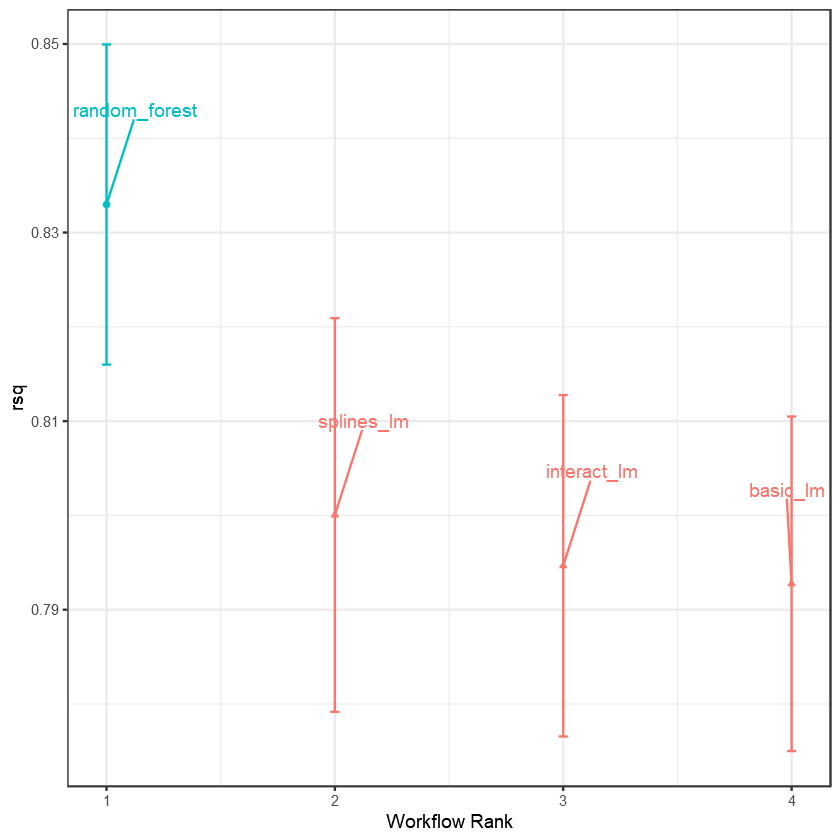

In [14]:
library(ggrepel)
autoplot(four_models, metric = "rsq") +
    geom_text_repel(aes(label = wflow_id), nudge_x = 1/8, nudge_y = 1/100) +
    theme(legend.position = "none")

# 
# 
# 
## 11.2 리샘플링 성능 비교

In [15]:
rsq_indiv_estimates <- collect_metrics(four_models, summarize = FALSE) %>% 
    filter(.metric == "rsq") 
rsq_indiv_estimates %>% head(3)

wflow_id,.config,preproc,model,id,.metric,.estimator,.estimate
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
random_forest,Preprocessor1_Model1,formula,rand_forest,Fold01,rsq,standard,0.8724463
random_forest,Preprocessor1_Model1,formula,rand_forest,Fold02,rsq,standard,0.8433044
random_forest,Preprocessor1_Model1,formula,rand_forest,Fold03,rsq,standard,0.8384557


# 
# 
#### 모델별 성능간의 상관관계 비교

id,random_forest,basic_lm,interact_lm,splines_lm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Fold01,0.8724463,0.8441590,0.8441893,0.8378595
Fold02,0.8433044,0.7903836,0.7974093,0.8128592
Fold03,0.8384557,0.8144102,0.8178844,0.8352393
Fold04,0.8448300,0.7935016,0.7910187,0.7981498
Fold05,0.8638114,0.8343171,0.8375939,0.8464008
Fold06,0.7870964,0.7596323,0.7648162,0.7697745
Fold07,0.8642478,0.8025220,0.8049347,0.8050461
Fold08,0.8224698,0.7776845,0.7777459,0.8023228
Fold09,0.8183622,0.7820389,0.7846681,0.7838652


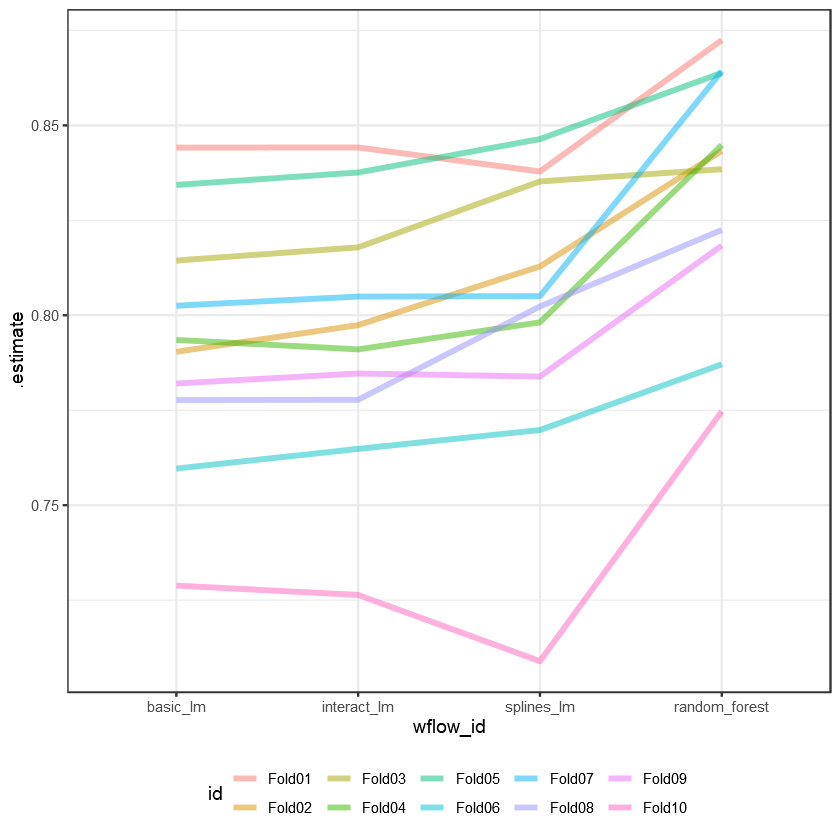

In [16]:
rsq_wider <- rsq_indiv_estimates %>% 
    select(wflow_id, .estimate, id) %>% 
    pivot_wider(id_cols = "id", names_from = "wflow_id", values_from = ".estimate")
rsq_wider

rsq_indiv_estimates %>% 
    mutate(wflow_id = reorder(wflow_id, .estimate)) %>% 
    ggplot(aes(x = wflow_id, y = .estimate, group = id, color = id)) + 
    geom_line(alpha = .5, lwd = 1.25) + 
    theme(legend.position = "bottom")

- 상관관계는 높으며, 모델 전체에서 리샘플링 내 상관관계가 크다는 것을 의미

In [17]:
corrr::correlate(rsq_wider %>% select(-id))

Correlation computed with
* Method: 'pearson'
* Missing treated using: 'pairwise.complete.obs'


term,random_forest,basic_lm,interact_lm,splines_lm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
random_forest,NA,0.9262563,0.9179297,0.8730169
basic_lm,0.9262563,NA,0.9961190,0.9430838
interact_lm,0.9179297,0.9961190,NA,0.9563947
splines_lm,0.8730169,0.9430838,0.9563947,NA


# 

- 상관 검정 결과, 상관계수는 통계적으로 유의

In [18]:
rsq_wider %>%
    with(cor.test(basic_lm, splines_lm)) %>%
    tidy() %>%
    select(estimate, starts_with("conf"))

estimate,conf.low,conf.high
<dbl>,<dbl>,<dbl>
0.9430838,0.7716642,0.9867735


# 
# 
#### 큰 상관계수 값이 가지는 의미 :

$\operatorname{Var}[X - Y] = \operatorname{Var}[X] + \operatorname{Var}[Y]  - 2 \operatorname{Cov}[X, Y]$

- 마지막 항은 두 항목 간의 공분산 => 크기가 큰 양의 공분산이 있는 경우 이 차이에 대한 통계적 검정은 두 모형의 차이를 비교하는데 있어 검정력이 부족할 수 있음
- **다시 말해, 리샘플링 vs 리샘플링 효과를 무시하면 모델 간 차이를 찾는 쪽으로 모델 비교가 편향될 수 있음**

- 예를 들어, R2값이 ±2% 이내이면 두 모델이 실질적으로 다르지 않다고 생각할 수 있음 => 이 경우 2% 미만의 차이는 통계적으로 유의하더라도 중요하지 않은 것으로 간주

# 
# 
## 11.3 가설 검정

In [19]:
rsq_indiv_estimates %>% print

# A tibble: 40 x 8
   wflow_id      .config             preproc model id    .metric .esti~1 .esti~2
   <chr>         <chr>               <chr>   <chr> <chr> <chr>   <chr>     <dbl>
 1 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.872
 2 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.843
 3 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.838
 4 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.845
 5 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.864
 6 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.787
 7 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.864
 8 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.822
 9 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.818
10 random_forest Preprocessor1_Mode~ formula rand~ Fold~ rsq     standa~   0.775
# ... wit

In [20]:
rsq_indiv_estimates %>% 
    select(id, rsq = .estimate, model = wflow_id) %>% 
    arrange(id, model) %>% 
    mutate(X1 = ifelse(model == "interact_lm", 1, 0),
           X2 = ifelse(model == "random_forest", 1, 0),
           X3 = ifelse(model == "splines_lm", 1, 0)) %>% 
    select(`Y = rsq` = rsq, model, X1, X2, X3, id) %>% print

# A tibble: 40 x 6
   `Y = rsq` model            X1    X2    X3 id    
       <dbl> <chr>         <dbl> <dbl> <dbl> <chr> 
 1     0.844 basic_lm          0     0     0 Fold01
 2     0.844 interact_lm       1     0     0 Fold01
 3     0.872 random_forest     0     1     0 Fold01
 4     0.838 splines_lm        0     0     1 Fold01
 5     0.790 basic_lm          0     0     0 Fold02
 6     0.797 interact_lm       1     0     0 Fold02
 7     0.843 random_forest     0     1     0 Fold02
 8     0.813 splines_lm        0     0     1 Fold02
 9     0.814 basic_lm          0     0     0 Fold03
10     0.818 interact_lm       1     0     0 Fold03
# ... with 30 more rows


# 
- 위의 X1, X2 및 X3 열은 모형 열의 값을 나타내는 지표

# 

####  모델 비교를 위해 수립한 ANOVA 모델 : 

$y_{ij} = \beta_0 + \beta_1x_{i1} + \ldots + \beta_px_{ip} + \epsilon_{ij}$

# 

- $\beta_0$은 기본 선형 모델에 대한 평균 $R^2$ 통계량 추정치(즉, 스플라인 또는 교호작용 없음). 
- $\beta_1$은 상호작용이 기본 선형 모형에 추가될 때 평균 $R^2$의 변화
- $\beta_2$는 기본 선형 모델과 랜덤 포레스트 모델 사이의 평균 $R^2$의 변화
- $\beta_3$은 기본 선형 모델과 상호 작용과 스플라인을 갖는 모델 사이의 평균 $R^2$의 변화

# 

- 한 번에 두 모델을 비교하는 간단하고 빠른 방법은 다음과 같은 차이를 사용하는 것. 

# 

#### spline_lm과 basic_lm의 성능 메트릭 (R2)에 대한 t-test

In [21]:
compare_lm <- rsq_wider %>%
    mutate(difference = splines_lm - basic_lm)

lm(difference ~ 1, data = compare_lm) %>%
    tidy(conf.int = TRUE) 

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.007295933,0.004384263,1.664119,0.130447,-0.002621958,0.01721382


In [22]:
rsq_wider %>%
    with( t.test(splines_lm, basic_lm, paired = TRUE) ) %>%
    tidy() 

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.007295933,1.664119,0.130447,9,-0.002621958,0.01721382,Paired t-test,two.sided


- **p-값은 확인 결과 스플라인 항의 수집이 영향을 미치지 않는 것으로 확인**. 
    - $R^2$의 차이는 0.73%로 추정. 
    
- p-값은 데이터의 통계적 요약(예: 두 비교 그룹 간의 표본 평균 차이)이 관측된 값과 같거나 더 극단적일 확률
    - 즉, 차이가 없다는 귀무 가설 하에서 이 분석이 여러 번 반복되었다면, p-값은 비교 시 관측된 결과가 얼마나 극단적일지를 반영합니다.



# 
# 
# 
## 11.4 베이지안 방법
# 

- 모델을 공식적으로 비교하기 위해 가설 테스트를 사용했을 뿐이지만 랜덤 효과와 베이지안 통계를 사용하여 이러한 공식적인 비교를 하는 데 더 일반적인 접근 방식을 취할 수 있음
- 모형이 분산 분석 방법보다 더 복잡하지만, p-값 접근법보다 더 단순하고 간단
    - 이전 분산 분석 모형의 형태 : $y_{ij} = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i3} + \epsilon_{ij}$
    - 여기서 잔차 $\epsilon_i$는 독립적이며 평균이 0이고 $\sigma$의 일정한 표준 편차를 갖는 가우시안 분포를 따른다고 가정
    - 이 가정으로부터, 통계 이론은 추정된 회귀 모수가 다변량 가우시안 분포를 따르고, 이로부터 p-값과 신뢰 구간을 도출한다는 것을 보여줌

- 베이지안 선형 모델은 추가적인 가정이 필요. 
    - 잔차에 대한 분포를 지정하는 것 외에도 모형 모수($\beta_j$) 및 $\sigma$)에 대한 사전 분포 규격이 필요
    - $\begin{align}
\epsilon_{ij} &\sim N(0, \sigma) \notag \\
\beta_j &\sim N(0, 10) \notag \\
\sigma &\sim \text{exponential}(1) \notag
\end{align}$


# 
# 
# 
### 랜덤 절편 모형

# 
- 리샘플링이 적절하게 모델링되도록 베이지안 분산 분석 모델을 조정하기 위해 '랜덤 절편 모델'을 고려
- 리샘플링이 절편을 변경하는 것만으로 모델에 영향을 미친다고 가정
    - 이는 리샘플링이 회귀 매개 변수 $\beta_j$\에 차등 영향을 미치는 것을 제한한다는 점에 유의
    - 리샘플링 간에 동일한 관계를 갖는 것으로 가정됩니다. 이 모형 방정식은 다음과 같음.
    - $y_{ij} = (\beta_0 + b_{i}) + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i3} + \epsilon_{ij}$


- 이 모델 구성의 경우 랜덤 효과의 사전 분포에 대해 추가 가정을 수행
    - 분포에 대한 합리적인 가정은 다른 종 모양의 곡선과 같은 또 다른 대칭 분포입니다. 
    - 요약 통계량 데이터의 유효 표본 크기가 10인 경우 표준 정규 분포보다 넓은 사전 분포를 사용. 
    - 우리는 유사한 가우스 분포보다 더 무거운 꼬리를 가진 단일 자유도(즉, $b_i \sim t(1)$)를 가진 t-분포를 사용





# 
#### tidyposterior 패키지
- 리샘플링된 모델을 비교하기 위해 베이지안 모델에 맞는 기능

# 
### ```tidyposterior::perf_mod()```
- 워크플로 세트의 경우 그룹이 워크플로에 해당하는 분산 분석 모형을 만듬 
    - 기존 모델은 튜닝 매개 변수를 최적화하지 않음. 세트의 워크플로 중 하나에 튜닝 매개 변수에 대한 데이터가 있는 경우 각 워크플로우에 대해 설정된 최상의 튜닝 매개 변수가 베이지안 분석에 사용. 다시 말해, 튜닝 매개 변수가 존재함에도 불구하고 ```perf_mod()```는 워크플로 간 비교에 초점을 맞춘다.
- 리샘플링을 사용하여 튜닝된 단일 모델을 포함하는 객체의 경우 ```perf_mod()```는 모델 내에서 비교
    - 이 경우 베이지안 분산 분석 모형에서 검사된 그룹화 변수는 조정 모수에 의해 정의된 하위 모형

- ```perf_mod()``` 함수는 둘 이상의 모델/워크플로우 결과와 연관된 성능 메트릭 열을 갖는 rsample에 의해 생성된 데이터 프레임을 가져올 수도 있음

- ```perf_mod()``` 함수는 이러한 유형의 객체에서 적절한 베이지안 모델을 결정하고 이를 리샘플링 통계와 일치시킨다. 이 예에서는 워크플로와 관련된 4개의 $R^2$ 통계 세트를 모델링합니다.

- tidyposterior 패키지는 stan 소프트웨어를 사용하여 rstanarm 패키지를 통해 모델을 지정하고 장착


In [28]:
library(tidyposterior)
library(rstanarm)

In [29]:
four_models %>% print

# A workflow set/tibble: 4 x 4
  wflow_id      info             option    result   
  <chr>         <list>           <list>    <list>   
1 random_forest <tibble [1 x 4]> <opts[0]> <rsmp[+]>
2 basic_lm      <tibble [1 x 4]> <opts[2]> <rsmp[+]>
3 interact_lm   <tibble [1 x 4]> <opts[2]> <rsmp[+]>
4 splines_lm    <tibble [1 x 4]> <opts[2]> <rsmp[+]>


In [25]:
rsq_anova <- perf_mod(four_models,
                      metric = "rsq",
                      prior_intercept = rstanarm::student_t(df = 1),
                      chains = 4,
                      iter = 5000,
                      seed = 1102)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 8.136 seconds (Warm-up)
Chain 1:                5.254 seconds (Sampling)
Chain 1:                13.39 se

In [26]:
model_post <- rsq_anova %>%
    tidy(seed = 1103)

glimpse(model_post)

Rows: 40,000
Columns: 2
$ model     <chr> "random_forest", "basic_lm", "interact_lm", "splines_lm", "r~
$ posterior <dbl> 0.8403239, 0.7991174, 0.8005733, 0.8095779, 0.8384184, 0.798~


# 
-  네 가지 다른 모델을 사용한 결정 계수에 대한 사후 분포

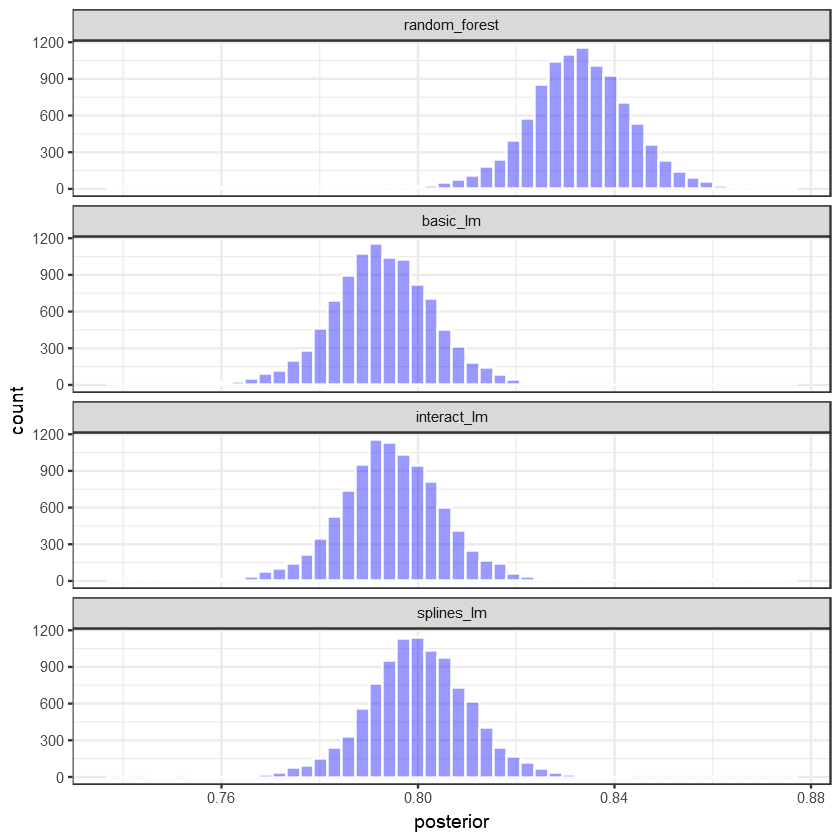

In [27]:
model_post %>% 
    mutate(model = forcats::fct_inorder(model)) %>%
    ggplot(aes(x = posterior)) + 
    geom_histogram(bins = 50, color = "white", fill = "blue", alpha = 0.4) + 
    facet_wrap(~ model, ncol = 1)

- 중첩 밀도 플롯

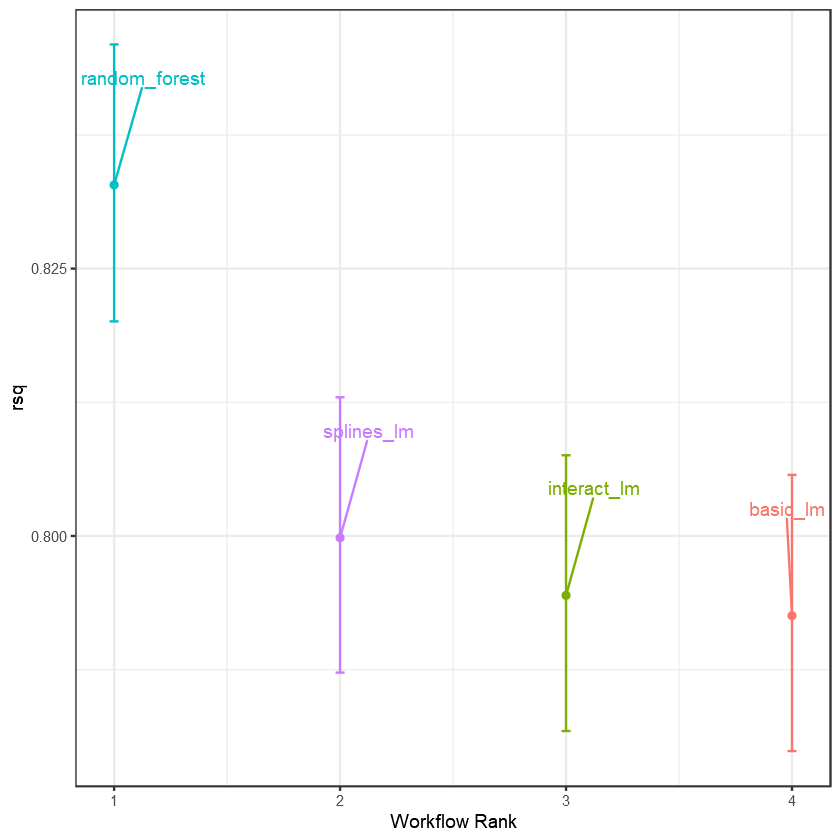

In [31]:
autoplot(rsq_anova) +
    geom_text_repel(aes(label = workflow), nudge_x = 1/8, nudge_y = 1/100) +
    theme(legend.position = "none")

- 베이지안 모델과 함께 리샘플링을 사용하는 한 가지 측면은 일단 매개 변수에 대한 사후 분포를 얻으면 매개 변수 조합에 대한 사후 분포를 얻는 것이 간단하다는 것

# 

### ```contrast_models()```


In [35]:
rsq_diff <- contrast_models(rsq_anova,
                            list_1 = "splines_lm", 
                            list_2 = "basic_lm", seed = 1104)
rsq_diff %>% glimpse 

Rows: 10,000
Columns: 4
$ difference <dbl> 0.010460470, 0.005956666, 0.009413796, 0.008226638, 0.00738~
$ model_1    <chr> "splines_lm", "splines_lm", "splines_lm", "splines_lm", "sp~
$ model_2    <chr> "basic_lm", "basic_lm", "basic_lm", "basic_lm", "basic_lm",~
$ contrast   <chr> "splines_lm vs. basic_lm", "splines_lm vs. basic_lm", "spli~


- 결정 계수의 차이에 대한 사후 분포

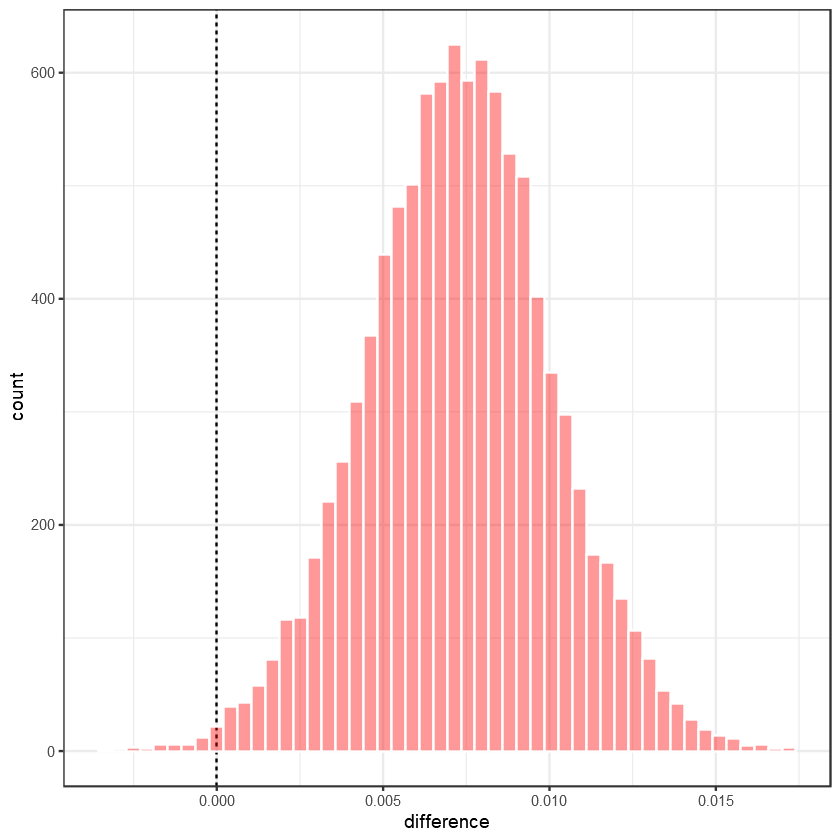

In [36]:
rsq_diff %>%  as_tibble() %>% 
    ggplot(aes(x = difference)) + 
    geom_vline(xintercept = 0, lty = 2) + 
    geom_histogram(bins = 50, color = "white", fill = "red", alpha = 0.4)

# 
- probability 열은 0보다 큰 사푸분포의 비율을 (diff의 양수값이 실제일 확률) 
    => 0에 가깝지 않아 통계적으로 실제 차이가 0보다 크다는 것을 확인



In [44]:
summary(rsq_diff, size = 0.02) %>%
    select(-starts_with("pract"))

contrast,probability,mean,lower,upper,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
splines_lm vs basic_lm,0.9951,0.007296108,0.002662759,0.01197416,0.02


# 

- practice_equiv 열은 [-size, size] 내에 있는 후방의 비율 (pract_neg와 practice_pos 열은 이 간격보다 아래 및 위에 있는 비율)
    - 이 값은 효과 크기에 대해 두 모델이 실질적으로 동일할 가능성이 압도적으로 높다는 것을 나타냄. 
    - 이전 plot에서 차이가 0이 아닐 가능성이 높다는 것을 알 수 있었지만, 동등성 검정은 실질적으로 의미가 없을 정도로 작다는 것을 시사



In [45]:
summary(rsq_diff, size = 0.02) %>%
    select(contrast, starts_with("pract"))

contrast,pract_neg,pract_equiv,pract_pos
<chr>,<dbl>,<dbl>,<dbl>
splines_lm vs basic_lm,0,1,0


# 

- 랜덤 포레스트 모델을 리샘플링한 선형 회귀 분석 중 하나 또는 둘 다와 비교하는 데 동일한 프로세스를 사용할 수 있음. 
- 실제로 ```perf_mod()```를 워크플로 세트와 함께 사용할 때 ```autoplot()```메서드는 각 워크플로를 현재 최고 성능 모델(이 경우 랜덤 포레스트 모델)와 비교하는 practice_equiv 결과를 표시할 수 있음.

# 
(ROPE (Regional Of Practical Equivalence) : 실제 동일 값 영역)

# 
- 2%의 효과 크기에 대한 실제 동등성의 확률

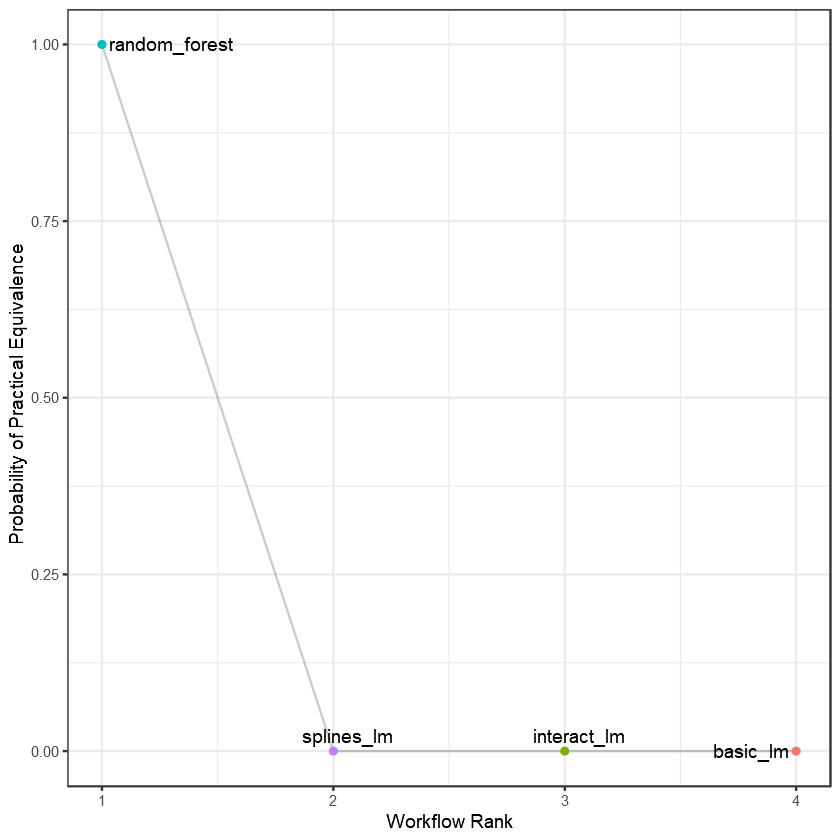

In [47]:
autoplot(rsq_anova, type = "ROPE", size = 0.02) +
    geom_text_repel(aes(label = workflow)) +
    theme(legend.position = "none")

# 
# 
### 리샘플링의 크기가 미치는 영향
- 리샘플링이 많을수록 전체 리샘플링 추정치의 정밀도가 증가. 

